In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import numpy as jnp, random as jr
from jax import tree_util as jtu
from jax import nn, lax

import matplotlib.pyplot as plt

from pymdp.agent import Agent
from pymdp.envs import TMaze

from pybefit.inference import (
    run_nuts,
    run_svi,
    default_dict_nuts,
    default_dict_numpyro_svi,
)

from pybefit.inference import NumpyroModel, NumpyroGuide
from pybefit.inference import Normal, NormalPosterior
from pybefit.inference.numpyro.likelihoods import pymdp_likelihood as likelihood
from numpyro.infer import Predictive


/Users/conorheins/Documents/Verses/pymdp/.venv311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
seed_key = jr.PRNGKey(101)

# setting the parameters for the environment
batch_size = 100 # batch_size, which in this case corresponds to the number of agents to fit in parallel
num_blocks = 25
num_timesteps = 5

reward_condition = None # 0 is reward in left arm, 1 is reward in right arm, None is random allocation
reward_probability = 0.9 # 90% chance of reward in the correct arm
punishment_probability = 0.8 # 80% chance of punishment in the other arm
cue_validity = 1.0 # 100% valid cues
dependent_outcomes = False # if True, punishment occurs as a function of reward probability (i.e., if reward probability is 0.8, then 20% punishment). If False, punishment occurs with set probability (i.e., 20% no outcome and punishment will only occur in the other (non-rewarding) arm)

# initialising the environment. see tmaze.py in pymdp/envs for the implementation details.
task = TMaze( 
    batch_size=batch_size, 
    reward_probability=reward_probability,     
    punishment_probability=punishment_probability, 
    cue_validity=cue_validity,          
    reward_condition=reward_condition,
    dependent_outcomes=dependent_outcomes
)

key, _key = jr.split(seed_key)
_, task = task.reset(jr.split(_key, batch_size))

In [4]:
#  setting A tensors from the environment parameters
A = task.params["A"]
A_dependencies = task.dependencies["A"]  # dependencies allow you to specify which state factors each observation modality depends on, so you dont have to store all the conditional dependencies between all state factors and each modality

# setting B tensors from the environment parameters
B = task.params["B"]
B_dependencies = task.dependencies["B"]  # dependencies allow you to specify which state factors each state factor depends on, so you dont have to store all the conditional dependencies between all state factors
 
# creating C tensors filled with zeros for [location], [reward], [cue] based on A shapes
C_reward = jnp.array([0., 2., -3.])  # prefer reward (index 1), avoid punishment (index 2)
C = [jnp.zeros((batch_size, a.shape[1]), dtype=jnp.float32) for a in A]
# setting preferences for outcomes only
C[1] = jnp.broadcast_to(C_reward, (batch_size, 3))

# creating D tensors [location], [reward] based on B shapes
D = [jnp.zeros((batch_size, b.shape[1]), dtype=jnp.float32) for b in B]
# D[0]: location - all zeros except location 0 (center) because the agent always starts in the center
D_loc = jnp.zeros((batch_size, B[0].shape[1]), dtype=jnp.float32) 
D_loc = D_loc.at[:,0].set(1.0)  # set center location to 1.0
D[0] = D_loc

# D[1]: reward location - uniform distribution
D_reward = jnp.ones((batch_size, B[1].shape[1]), dtype=jnp.float32) 
D_reward = D_reward / jnp.sum(D_reward, axis=1, keepdims=True)  # normalize to get uniform distribution
D[1] = D_reward

In [5]:
agents = Agent(
    A, B, C=C, D=D, A_dependencies=A_dependencies, B_dependencies=B_dependencies, batch_size=batch_size
)

model_dims = agents.get_model_dimensions()  # get model dimensions for useful downstream applications

In [6]:
# test env step method
keys = jr.split(key, batch_size)
obs, task = task.step(keys)

actions = jnp.zeros((batch_size, len(model_dims["num_controls"])), dtype=jnp.uint8)
obs, task = task.step(keys, actions=actions)

task.reset(jr.split(keys[-1], batch_size))

([Array([[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [

In [7]:
num_params = 4 # two likelihood contingency params (reward prob, punishment prob), outcome preference param, prior state prob param
num_agents = batch_size
prior = Normal(num_params, num_agents, backend="numpyro")

def transform(z):
    na, np = z.shape

    reward_prob = nn.sigmoid(z[..., 0])
    punish_prob = nn.sigmoid(z[..., 1])
    lam = nn.softplus(z[..., 2])
    d = nn.sigmoid(z[..., 3])

    A = lax.stop_gradient(task.params["A"])
    B = lax.stop_gradient(task.params["B"])

    zeros = jnp.zeros_like(reward_prob)

    side = jnp.broadcast_to(jnp.array([[1., 1.], [0., 0.], [0., 0.]]), (na, 3, 2))
    left_col = jnp.stack([
        jnp.stack([1 - reward_prob, 1 - punish_prob], -1),
        jnp.stack([reward_prob, zeros], -1),
        jnp.stack([zeros, punish_prob], -1),
    ], -2)
    right_col = jnp.stack([
        jnp.stack([1 - punish_prob, 1 - reward_prob], -1),
        jnp.stack([zeros, reward_prob], -1),
        jnp.stack([punish_prob, zeros], -1),
    ], -2)
    A[1] = jnp.stack([side, left_col, right_col, side, side], axis=-2)

    C = [
        jnp.zeros((na, A[0].shape[1])),
        jnp.expand_dims(lam, -1) * jnp.array([0., 1., -1.]),
        jnp.zeros((na, A[2].shape[1])),
    ]
    D = [
        jnp.zeros((na, B[0].shape[1])).at[:, 0].set(1.0),
        jnp.stack([d, 1 - d], -1),
    ]

    return Agent(
        A,
        B,
        C=C,
        D=D,
        A_dependencies=A_dependencies,
        B_dependencies=B_dependencies,
        batch_size=na,
    )


key, _key = jr.split(seed_key)
z = jr.normal(_key, shape=(num_agents, num_params)) / 10

agents = transform(z)

In [8]:
opts_task = {
    "task": task,
    "num_blocks": num_blocks,
    "num_trials": num_timesteps,
    "num_agents": num_agents,
}
opts_model = {"prior": {}, "transform": {}, "likelihood": opts_task}

model = NumpyroModel(prior, transform, likelihood, opts=opts_model)

pred = Predictive(model, num_samples=1)
key, _key = jr.split(key)
samples = pred(_key)

In [9]:
# perform inference on parameters using no-u-turn sampler (NUTS)
# opts_sampling dictionary can be used to specify various parameters
# either for the NUTS kernel or MCMC sampler
measurements = {
    "outcomes": [outcomes[0] for outcomes in samples["outcomes"]],
    "multiactions": samples["multiactions"][0],
}

opts_sampling = default_dict_nuts
opts_sampling["num_warmup"] = 400
opts_sampling["num_samples"] = 100
opts_sampling["sampler_kwargs"] = {"kernel": {}, "mcmc": {"progress_bar": True}}
print(opts_sampling)

mcmc_samples, mcmc = run_nuts(model, measurements, opts=opts_sampling)

{'seed': 0, 'num_samples': 100, 'num_warmup': 400, 'sampler_kwargs': {'kernel': {}, 'mcmc': {'progress_bar': True}}}


sample: 100%|██████████| 500/500 [08:02<00:00,  1.04it/s, 15 steps of size 2.89e-01. acc. prob=0.89]


In [10]:
# perform inference on parameters using black-box stochastic variational inference (SVI in numpyro)
# opts_svi dictionary can be used to specify various parameters
# for the SVI optimization algorithm
measurements = {
    "outcomes": [outcomes[0] for outcomes in samples["outcomes"]],
    "multiactions": samples["multiactions"][0],
}

posterior = NumpyroGuide(NormalPosterior(num_params, num_agents, backend="numpyro"))

# perform inference using stochastic variational inference
opts_svi = default_dict_numpyro_svi | {"iter_steps": 1_000}
print(opts_svi)

svi_samples, svi, results = run_svi(model, posterior, measurements, opts=opts_svi)

{'seed': 0, 'enumerate': False, 'iter_steps': 1000, 'optim': None, 'optim_kwargs': {'learning_rate': 0.001}, 'elbo_kwargs': {'num_particles': 10, 'max_plate_nesting': 1}, 'svi_kwargs': {'progress_bar': True, 'stable_update': True}, 'sample_kwargs': {'num_samples': 100}}


100%|██████████| 1000/1000 [07:38<00:00,  2.18it/s, init loss: 19907.8105, avg. loss [951-1000]: 18920.7012]


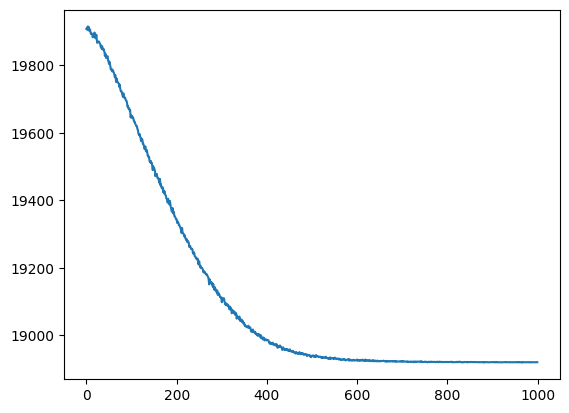

In [11]:
plt.plot(results.losses)

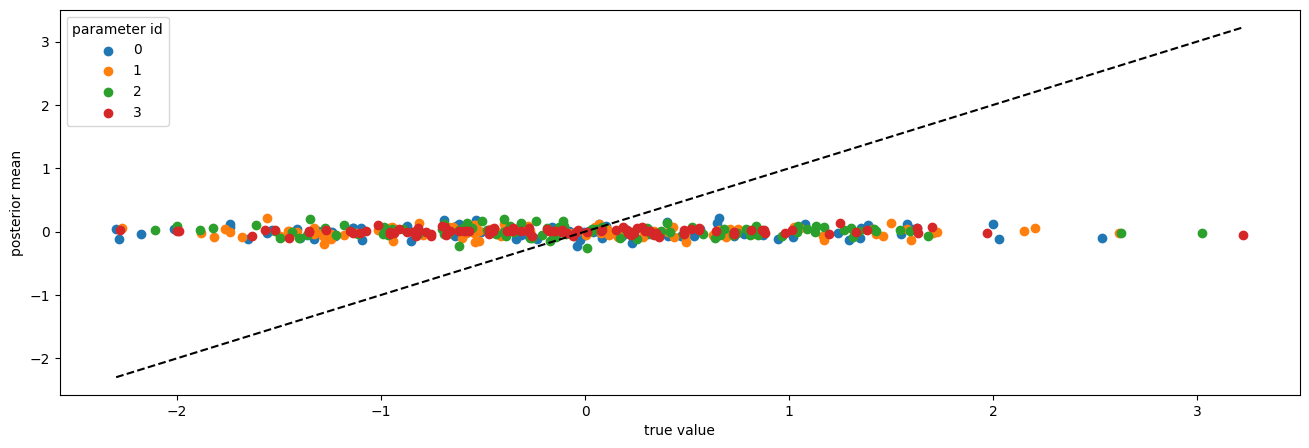

In [12]:
plt.figure(figsize=(16, 5))
ground_truth_z = samples['z'][0]
for i in range(num_params):
    plt.scatter(ground_truth_z[:, i], mcmc_samples["z"].mean(0)[:, i], label=i)

plt.plot((ground_truth_z.min(), ground_truth_z.max()), (ground_truth_z.min(), ground_truth_z.max()), "k--")
plt.ylabel("posterior mean")
plt.xlabel("true value")
plt.legend(title="parameter id")

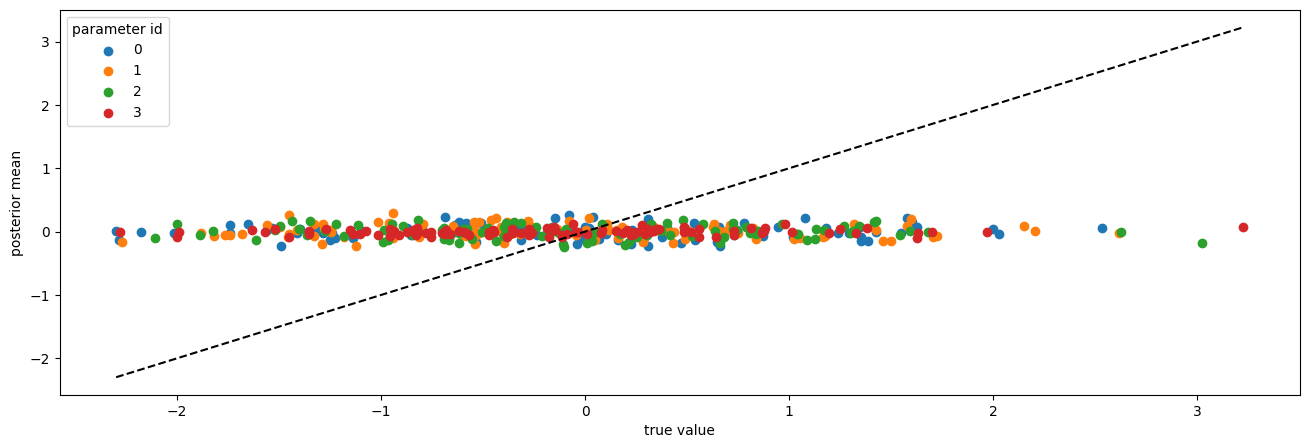

In [13]:
plt.figure(figsize=(16, 5))
ground_truth_z = samples['z'][0]
for i in range(num_params):
    plt.scatter(ground_truth_z[:, i], svi_samples["z"].mean(0)[:, i], label=i)

plt.plot((ground_truth_z.min(), ground_truth_z.max()), (ground_truth_z.min(), ground_truth_z.max()), "k--")
plt.ylabel("posterior mean")
plt.xlabel("true value")
plt.legend(title="parameter id")